# The 1/n family

We play with the $1/n$ portfolio. We start with a vanilla implementation using daily rebalancing.
Every portfolio should be the solution of a convex optimization problem, see https://www.linkedin.com/pulse/stock-picking-convex-programs-thomas-schmelzer. We do that and show two methods to construct the portfolio with the minimization of an Euclidean norm and the maximization of the Entropy of the underlying weights.

We also play with sparse updates, e.g. rather than rebalancing daily, we act only once the deviation of our drifted portfolio got too large from the target $1/n$ portfolio.

In [3]:
import pandas as pd
import numpy as np

# Get rid of findfont: Font family 'Arial' not found.
# when running a remote notebook on Jupyter Server on Ubuntu Linux server
import logging
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

from cvx.simulator import Builder
pd.options.plotting.backend = "plotly"

In [41]:
# load prices from flat csv file
prices = pd.read_csv("data/stock-prices.csv", header=0, index_col=0, parse_dates=True)

In [43]:
# Implement the 1/n portfolio using the Builder
builder = Builder(prices=prices, initial_aum=1e6)

np.random.seed(42)
for _, state in builder:
    assets = state.assets
    n = len(assets)
    builder.weights = np.ones(n)/n
    # it's important to also set the aum after setting the weights
    # Here one could apply trading costs
    # Access via state.trades, etc.
    builder.aum = state.aum

portfolio = builder.build()

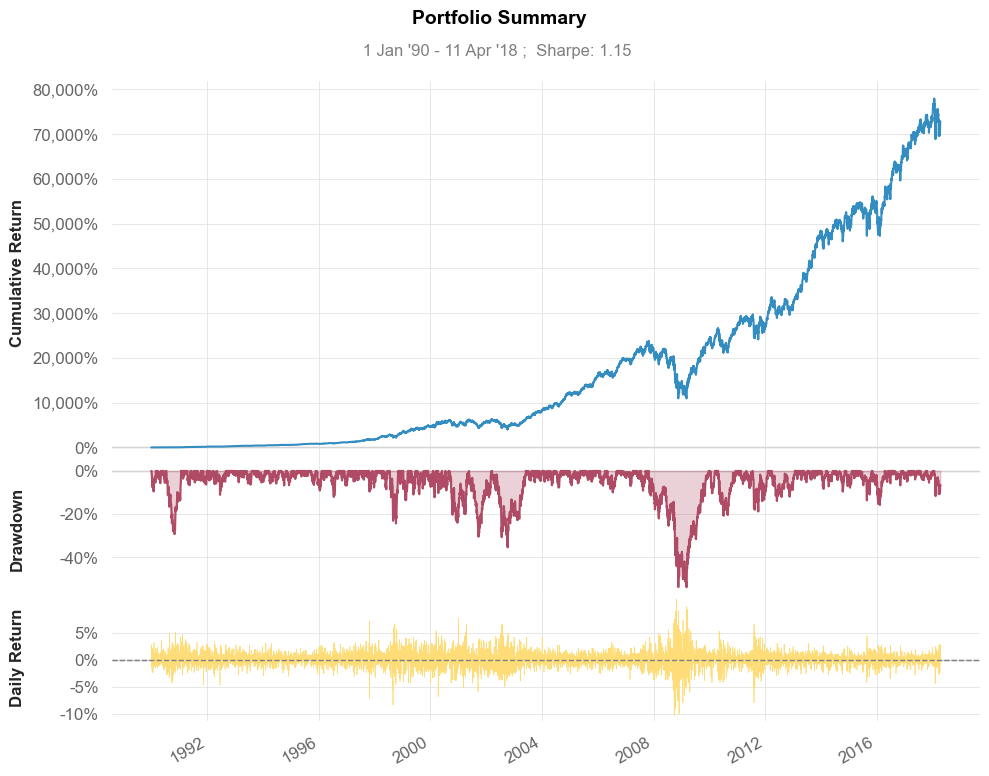

In [12]:
portfolio.snapshot()

## With cvxpy

Formulating the problem above as a convex program is most useful when additional constraints have to be reflected.
It also helps to link the 1/n portfolio to Tikhonov regularization and interpret its solution as a cornercase for 
more complex portfolios we are building

In [13]:
import cvxpy as cp

### Classic

We minimize the Euclidean norm of the weight vector. Same results as above but with opten door to the world of convex paradise.

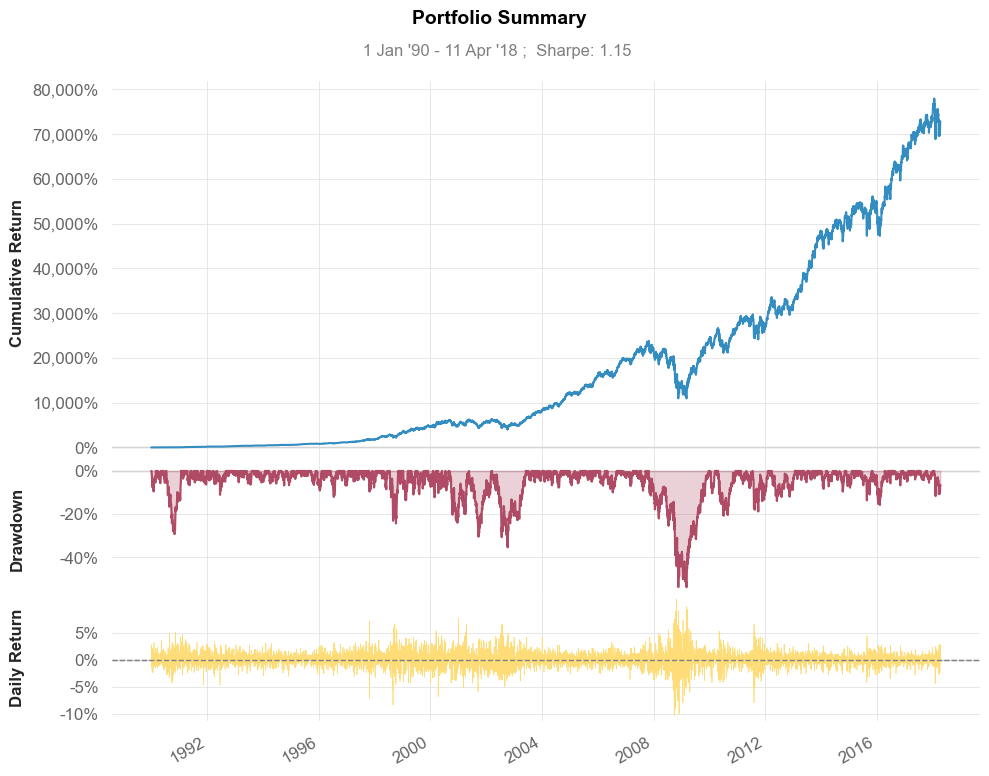

In [44]:
builder = Builder(prices=prices, initial_aum=1e6)

for _, state in builder:
    assets = state.assets
    n = len(assets)
    weights = cp.Variable(n)
    objective = cp.norm(weights, 2)
    constraints = [weights >= 0, cp.sum(weights) == 1]
    # we are using the new CLARABEL solver
    cp.Problem(objective=cp.Minimize(objective), constraints=constraints).solve(solver=cp.CLARABEL)
    # update weights & aum as before
    builder.weights = weights.value
    builder.aum = state.aum

portfolio = builder.build()
portfolio.snapshot()

### With entropy

One can also maximize the entropy to arrive at the same result

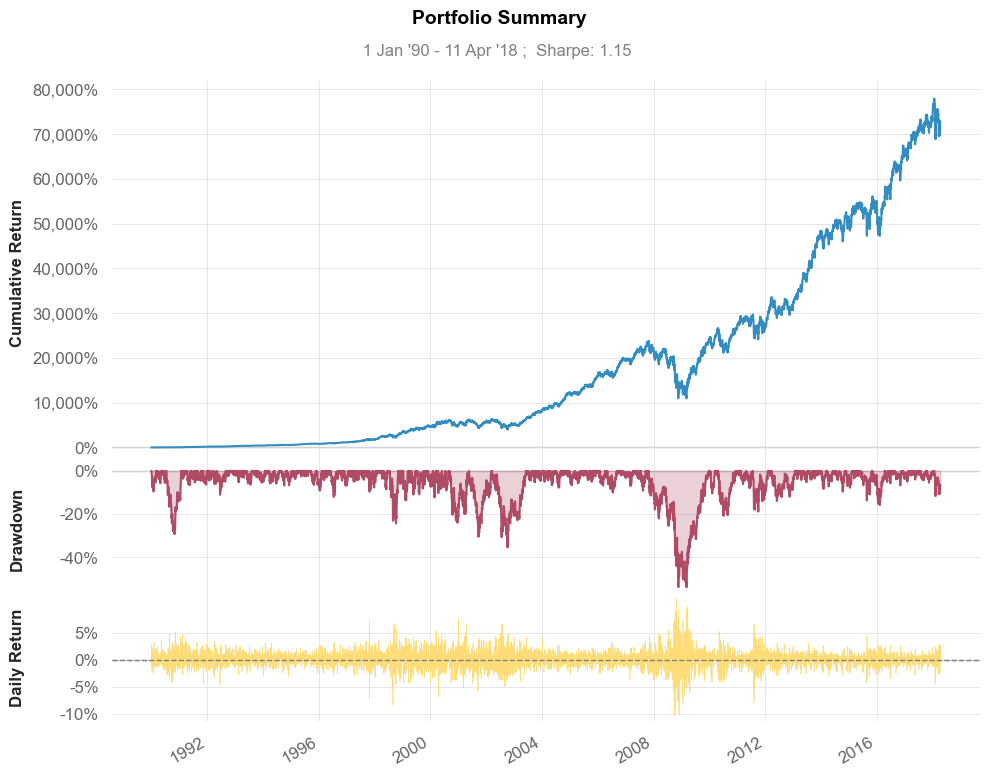

In [45]:
builder = Builder(prices=prices, initial_aum=1e6)

np.random.seed(42)
for _, state in builder:
    assets = state.assets
    n = len(assets)
    weights = cp.Variable(n)
    objective = cp.sum(cp.entr(weights))
    constraints = [weights >= 0, cp.sum(weights) == 1]
    cp.Problem(objective=cp.Maximize(objective), constraints=constraints).solve(solver=cp.CLARABEL)
    # update weights & aum as before
    builder.weights = weights.value
    builder.aum = state.aum

portfolio = builder.build()
portfolio.snapshot()

## With sparse updates

In practice we do not want to rebalance the portfolio every day. We tolerate our portfolio is not an exact $1/n$ portfolio. We may expect slightly weaker results

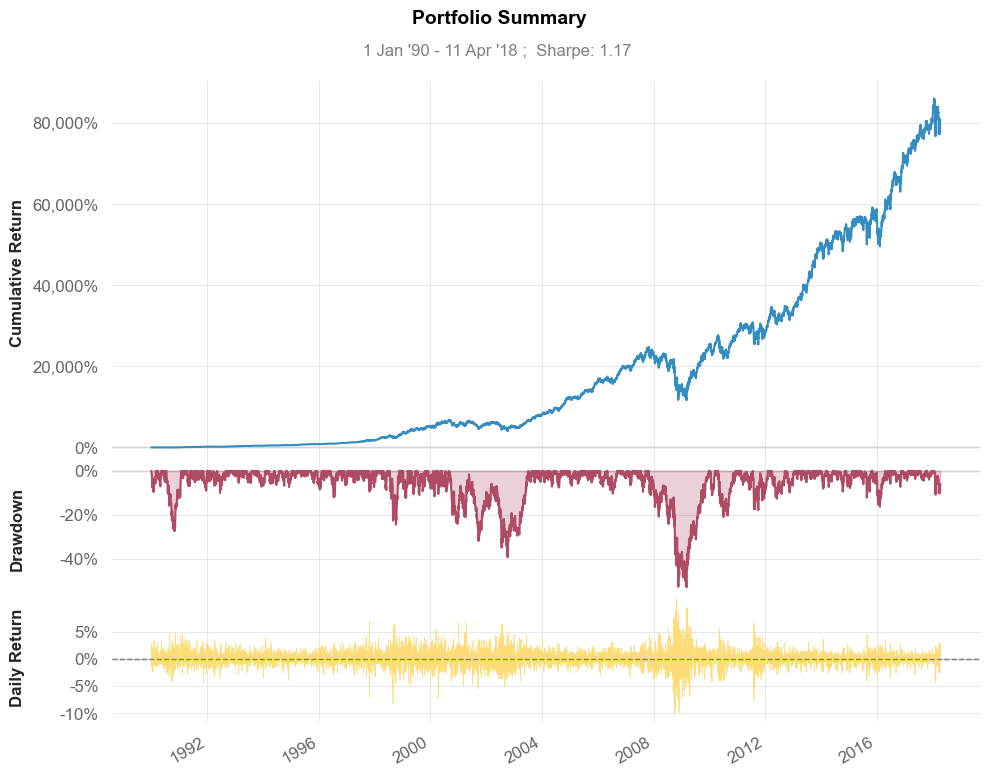

In [40]:
builder = Builder(prices=prices, initial_aum=1e6)

np.random.seed(42)
for _, state in builder:
    assets = state.assets
    n = len(assets)
    
    target = np.ones(n)/n
    
    # todo: this should be state.drifted...
    drifted = state.weights[state.assets].fillna(0.0)

    delta = (target - drifted).abs().sum()
    
    if delta > 0.20:
        builder.weights = target
    else:
        builder.position = state.position
        # or
        # builder.weights = drifted
        # builider.cashposition = state.cashposition
    
    builder.aum = state.aum

portfolio = builder.build()
portfolio.snapshot()